## Initialization: Import devices, modules and start station

In [1]:
import sys
sys.path.append('C:/QCodes drivers and scripts/Drivers')

from PLH250P_current_source_dummy import TTi
from PLH250P_current_source_TCP import current_set,power_up as current_source_on,power_down as current_source_off
current_source = TTi('TTi')


import VNA_Anritsu as VNA_Anritsu
vna_tvf= VNA_Anritsu.MS46522B('VNA', 'TCPIP::192.168.0.52',  init_s_params=False)
VNA_mode = 't'
if VNA_mode == 't':
    vna_tvf.write(':CALCulate1:PARameter1:DEFine S21')
    vna_tvf.add_channel('S21')

from RS_SMB_100A import SMB100A
# MW_source_1_tvf = SMB100A('SMB100A_1', 'TCPIP0::192.168.0.53::inst0::INSTR')
# MW_source_2_tvf = SMB100A('SMB100A_2', 'TCPIP0::192.168.0.54::inst0::INSTR')

# from RS_FSQ import RS_FSQ
# RS_SA_tvf = RS_FSQ('RS_FSQ', 'TCPIP0::192.168.0.61::inst0::INSTR')

# from MW_switch_controller import set_rt_switch,set_cryo_switch

Connected to: Dummy corp current source 001 (serial:dummy 100, firmware:None) in 0.00s
Connected to: ANRITSU MS46522B (serial:1728106, firmware:V2019.12.1,V3.3.12) in 0.05s


In [2]:
import sys
import qcodes as qc
from qcodes.logger.logger import start_all_logging
import datetime
from qcodes.dataset.plotting import plot_dataset
import numpy as np
import matplotlib.pyplot as plt
#qcodes.config.subscription.default_subscribers = ["Plottr"]
from time import sleep

from pprint import pprint
import json


sys.path.append('C:\QCodes drivers and scripts\Scripts\Arpit\Modules')
from notify import snotify
from progress_barV2 import bar

# import addcopyfighandler
from general_functions import find_nearest

In [3]:
%matplotlib widget
# %matplotlib inline

In [4]:
start_all_logging()

Logging hadn't been started.
Activating auto-logging. Current session state plus future input saved.
Filename       : C:\Users\nicolas.roch\.qcodes\logs\command_history.log
Mode           : append
Output logging : True
Raw input log  : False
Timestamping   : True
State          : active
Qcodes Logfile : C:\Users\nicolas.roch\.qcodes\logs\230118-324-qcodes.log


In [5]:
#create a station
station = qc.Station()
station.add_component(vna_tvf)
station.add_component(current_source)
# station.add_component(MW_source_1_tvf)
# station.add_component(MW_source_2_tvf)
# station.add_component(RS_SA_tvf)
station.snapshot()
station.components

{'VNA': <MS46522B: VNA>, 'TTi': <TTi: TTi>}

In [6]:
# Load experiment details
experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment = json.loads(''.join(experiment))

user = experiment['details']['user']
# date = experiment['details']['date']
date = '-'.join(str(datetime.date.today()).split('-'))
description = experiment['details']['description']
cooldown = experiment['details']['cooldown']
database_name = date+"_"+'CD_'+cooldown+'_'+user+"_"+description
# database_name = '2021-11-24_CD_05_11_GC_AR_3WM and RK TWPAs'
database_name

#Create or Initialize the database
qc.initialise_or_create_database_at("D:/Data_QCodes/"+database_name)
qc.config.core.db_location

'D:/Data_QCodes/2023-01-18_CD_23_01_17_AR_GL_GC_squeezing_gen2'

In [7]:
device_ids = experiment['device_ids']
print(str(experiment['current_device']['current_device']))

B2


## Sweep Flux and acquireVNA trace

In [14]:
parameter_snap={}

# VNA
start_freq = 3
end_freq = 13
points_per_gigahz = 100
VNA_power = -30
IF_bandwidth = 1000
Averages = 1
points_VNA=1+(end_freq-start_freq)*points_per_gigahz
points_VNA=int(points_VNA)
# points_VNA=5001
parameter_snap['vna']={'start_freq':start_freq,'end_freq':end_freq,'points_per_gigahz':points_per_gigahz,'VNA_power':VNA_power,'IF_bandwidth':IF_bandwidth,'Averages':Averages,'points':points_VNA}

# Current source
I_start = 0
I_end = 30
I_step = 1
points_I= int(abs(I_end - I_start)/I_step)+1
parameter_snap['flux']={'I_start':I_start,'I_end':I_end,'I_step':I_step}


vna_tvf.channels.S21.bandwidth(IF_bandwidth)
vna_tvf.channels.S21.power(VNA_power)
vna_tvf.channels.S21.avg(Averages)
vna_tvf.channels.npts(points_VNA)
vna_tvf.channels.start(start_freq*1e9)
vna_tvf.channels.stop(end_freq*1e9)


# Initialize devices and measurement
vna_tvf.rf_on()
vna_tvf.cont_meas_on()
current_source_on()
current_set(I_start)
# MW_source_1_tvf.status('off')
# MW_source_2_tvf.status('off')
# set_rt_switch('NC')

experiment_file = open('C:\QCodes drivers and scripts\Scripts\Arpit\_experiment_details.json','r')
experiment = experiment_file.readlines()
experiment = json.loads(''.join(experiment))
switch_position = experiment['current_device']['current_device']
exp_name = 'Transmission vs flux'
sample_name = str(switch_position) + ' : ' + device_ids[switch_position]
# sample_name = 'RKTWPA 01:32:RK 700cells'

exp=qc.load_or_create_experiment(experiment_name=exp_name,
                          sample_name=sample_name)

meas = qc.Measurement(exp=exp, station=station) 
meas.register_parameter(current_source.current) 
meas.register_parameter(vna_tvf.channels.S21.trace_mag_phase, setpoints=(current_source.current,)) 
meas.write_period = 2


with meas.run() as datasaver:
    for I in bar(np.linspace(I_start, I_end, points_I)):
        I=round(I,3)
        current_set(I)
        get_v = vna_tvf.channels.S21.trace_mag_phase.get()
        datasaver.add_result((current_source.current, I),
                             (vna_tvf.channels.S21.trace_mag_phase, get_v))

id_num=datasaver.dataset.run_id
qc.load_by_run_spec( captured_run_id=id_num).add_metadata('parameter_snap',json.dumps(parameter_snap))
            

            
# Shutdown devices
# vna_tvf.rf_off()
# vna_tvf.cont_meas_off()
# current_set(0)
# snotify('arpit.ranadive@gmail.com','Finished: '+exp_name+' '+sample_name)

Starting experimental run with id: 5. 


2023-01-18 12:37:13,909 ¦ qcodes.dataset.measurements ¦ WARNING ¦ measurements ¦ __exit__ ¦ 666 ¦ An exception occured in measurement with guid: aaaaaaaa-0000-0000-0000-0185c4aa3db2;
Traceback:
Traceback (most recent call last):
  File "C:\Users\nicolas.roch\AppData\Local\Temp\ipykernel_324\2219577505.py", line 61, in <module>
    get_v = vna_tvf.channels.S21.trace_mag_phase.get()
  File "C:\ProgramData\Anaconda3\envs\qcodes\lib\site-packages\qcodes\parameters\parameter_base.py", line 570, in get_wrapper
    raw_value = get_function(*args, **kwargs)
  File "C:\QCodes drivers and scripts/Drivers\VNA_Anritsu.py", line 66, in get_raw
    data = self._instrument._get_sweep_data(force_polar = True)
  File "C:\QCodes drivers and scripts/Drivers\VNA_Anritsu.py", line 501, in _get_sweep_data
    time.sleep(0.1)
KeyboardInterrupt



Received SIGINT, Will interrupt at first suitable time. Send second SIGINT to interrupt immediately.


KeyboardInterrupt: 

In [9]:
captured_run_id = id_num
# captured_run_id = 3
dataset = qc.load_by_run_spec(captured_run_id=captured_run_id)
meta = json.loads(dataset.get_metadata('parameter_snap'))
points_VNA = meta['vna']['points']
start_freq = meta['vna']['start_freq']
end_freq = meta['vna']['end_freq']
points_per_gigahz = meta['vna']['points_per_gigahz']
I_start = meta['flux']['I_start']
I_end = meta['flux']['I_end']
I_step = meta['flux']['I_step']
VNA_power = meta['vna']['VNA_power']

dataset

results #4@D:\Data_QCodes\2023-01-18_CD_23_01_17_AR_GL_GC_squeezing_gen2
------------------------------------------------------------------------
TTi_current - numeric
VNA_S21_S21_frequency - numeric
VNA_S21_magnitude - numeric
VNA_S21_phase - numeric

In [10]:
meta

{'vna': {'start_freq': 3,
  'end_freq': 13,
  'points_per_gigahz': 100,
  'VNA_power': -30,
  'IF_bandwidth': 1000,
  'Averages': 1,
  'points': 1001},
 'flux': {'I_start': 0, 'I_end': 30, 'I_step': 0.25}}

In [11]:
flux_data=list(dict.fromkeys(dataset.get_parameter_data('VNA_S21_magnitude')['VNA_S21_magnitude']['TTi_current']))
freq_data=dataset.get_parameter_data('VNA_S21_magnitude')['VNA_S21_magnitude']['VNA_S21_S21_frequency'][0:points_VNA]*1e-9
magnitude=(dataset.get_parameter_data('VNA_S21_magnitude')['VNA_S21_magnitude']['VNA_S21_magnitude']).reshape(len(flux_data),len(freq_data))

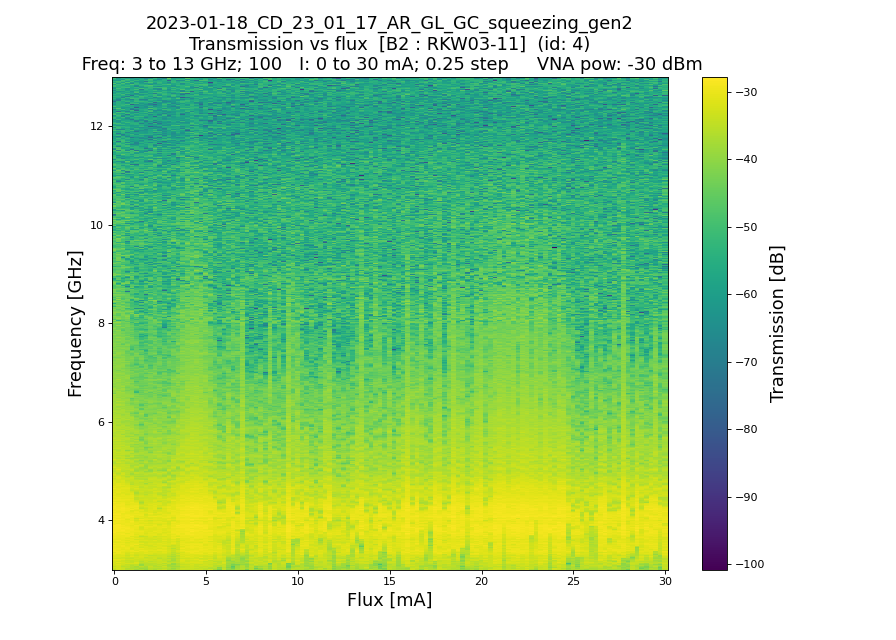

In [12]:
exp_name = dataset.exp_name
sample_name = dataset.sample_name

plot_title=database_name+'\n'+exp_name+'  ['+sample_name+']  (id: '+str(captured_run_id)+')'
plot_title+='\n Freq: '+str(start_freq)+' to '+str(end_freq)+' GHz; '+str(points_per_gigahz)+'   I: '+str(I_start)+' to '+str(I_end)+' mA; '+str(I_step)+' step     VNA pow: '+str(VNA_power)+' dBm'


plt.figure(figsize=(14*0.8, 10*0.8), dpi= 80) #facecolor='w', edgecolor='k'

X, Y = np.meshgrid(np.array(flux_data),np.array(freq_data))
Z = magnitude.T
plt.pcolor(X, Y, Z)
# plt.pcolor(X, Y, Z, vmin=-55, vmax=-15)
# plt.axvline(-0.5, style='--')
cbar=plt.colorbar()
cbar.set_label('Transmission [dB]', size=16)

plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=14*1.2)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14*1.2)  

x_label='Flux [mA]'
y_label='Frequency [GHz]'
plt.xlabel(x_label, size=16)
plt.ylabel(y_label, size=16)
plt.title(plot_title, size=16)
# plt.axvline(0.9)
plt.tight_layout
plt.show()

In [13]:
sample_name

'B2 : RKW03-11'

<IPython.core.display.Javascript object>


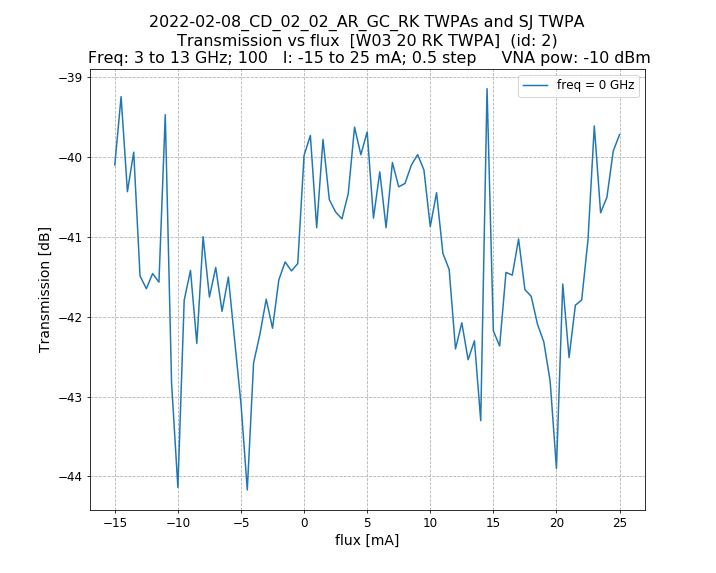

In [15]:
freq_list=np.array([0])

exp_name = dataset.exp_name
sample_name = dataset.sample_name

plot_title=database_name+'\n'+exp_name+'  ['+sample_name+']  (id: '+str(captured_run_id)+')'
plot_title+='\n Freq: '+str(start_freq)+' to '+str(end_freq)+' GHz; '+str(points_per_gigahz)+'   I: '+str(I_start)+' to '+str(I_end)+' mA; '+str(I_step)+' step     VNA pow: '+str(VNA_power)+' dBm'


# plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
# plot_title+='\n Pump '+str(pump_power)+' dBm @ '+str(pump_frequency)+' GHz    Freq: '+str(start_freq)+' to '+str(end_freq)+';'+str(points_per_gigahz)


plt.figure(figsize=(10, 8), dpi= 80) #facecolor='w', edgecolor='k'
x_label='flux [mA]'
y_label='Transmission [dB]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for freq_ind in freq_list:
    plt.plot(flux_data,magnitude[:, find_nearest(freq_data,freq_ind) ],label='freq = '+str(freq_ind)+' GHz')#marker="."
    
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)
# plt.axvline(5)

plt.legend(fontsize = 12)
# plt.xlim(3, 12)
# plt.ylim(-100, -25)
plt.show()   

In [22]:
print(len(magnitude[:,0 ]))
print(len(flux_data))

401
401


In [37]:
freq_int=find_nearest(freq_data,10.36)
minn=np.min(magnitude[:, freq_int ])
minn_arg=find_nearest((magnitude[:, freq_int ]),minn)
print(minn_arg)

58


In [ ]:
np.min()

<IPython.core.display.Javascript object>


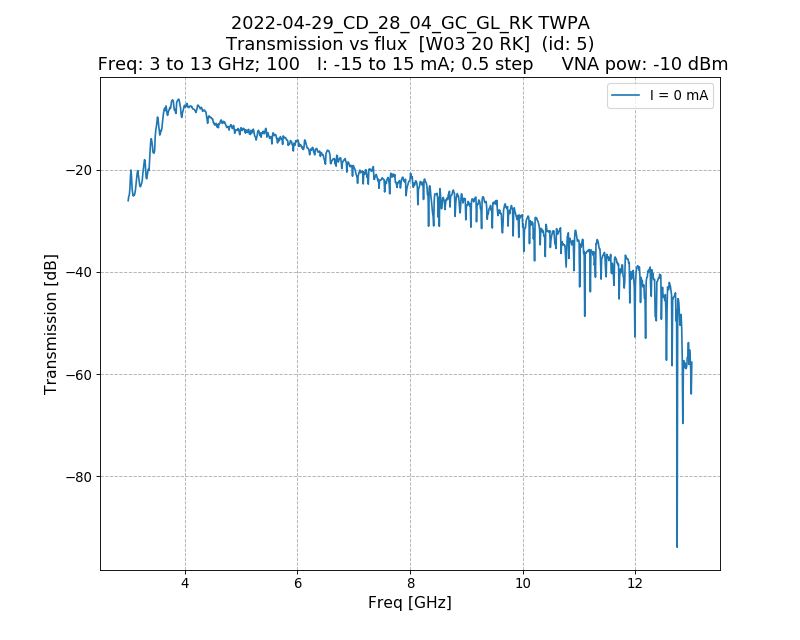

In [30]:
current_list=np.array([0])

# plot_title=database_name+'\n'+exp_name.split(':')[0]+'  ['+sample_name+']  (id_on: '+str(captured_run_id_on)+') (id_off: '+str(captured_run_id_off)+')'
# plot_title+='\n Pump '+str(pump_power)+' dBm @ '+str(pump_frequency)+' GHz    Freq: '+str(start_freq)+' to '+str(end_freq)+';'+str(points_per_gigahz)
exp_name = dataset.exp_name
sample_name = dataset.sample_name

plot_title=database_name+'\n'+exp_name+'  ['+sample_name+']  (id: '+str(captured_run_id)+')'
plot_title+='\n Freq: '+str(start_freq)+' to '+str(end_freq)+' GHz; '+str(points_per_gigahz)+'   I: '+str(I_start)+' to '+str(I_end)+' mA; '+str(I_step)+' step     VNA pow: '+str(VNA_power)+' dBm'


plt.figure(figsize=(10, 8), dpi= 80) #facecolor='w', edgecolor='k'
x_label='Freq [GHz]'
y_label='Transmission [dB]'

plt.rc('axes', labelsize=10)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('grid', linestyle="--")
plt.grid(True)

for current in current_list:
#     plt.plot(freq_data,magnitude[find_nearest(flux_data,current)]-mag_t,label='I = '+str(current)+' mA')#marker="."
    plt.plot(freq_data,magnitude[find_nearest(flux_data,current)],label='I = '+str(current)+' mA')#marker="."
    
plt.xlabel(x_label, size=14)
plt.ylabel(y_label, size=14)
plt.title(plot_title, size=16)
# plt.axvline(5)

plt.legend(fontsize = 12)
# plt.xlim(3, 12)
# plt.ylim(-100, -25)
plt.show()    

In [15]:
captured_run_id = 1
VNA_mode = 't' 

dataset = qc.load_by_run_spec(captured_run_id=captured_run_id)
print(dataset)

exp_name = dataset.exp_name
sample_name = dataset.sample_name
meta = json.loads(dataset.get_metadata('parameter_snap'))
start_freq = meta['vna']['start_freq']
end_freq = meta['vna']['end_freq']
points_per_gigahz = meta['vna']['points_per_gigahz']
VNA_power =  meta['vna']['VNA_power']
VNA_mode =  meta['vna']['VNA_mode']

if VNA_mode == 't':
    
    mag_t = dataset.get_parameter_data('magnitude')['magnitude']['magnitude']
    phase_t = dataset.get_parameter_data('phase')['phase']['phase']
    freq_data_t = dataset.get_parameter_data('VNA_S21_S21_frequency')['VNA_S21_S21_frequency']['VNA_S21_S21_frequency'][:points_per_gigahz*(end_freq-start_freq)+1]*1e-9
    
elif VNA_mode == 'r':
    
    mag_r = dataset.get_parameter_data('magnitude')['magnitude']['magnitude']
    phase_r = dataset.get_parameter_data('phase')['phase']['phase']
    freq_data_r = dataset.get_parameter_data('VNA_S11_S11_frequency')['VNA_S11_S11_frequency']['VNA_S11_S11_frequency'][:points_per_gigahz*(end_freq-start_freq)+1]*1e-9

results #1@D:\Data_QCodes\2021-11-08_CD_05_11_GC_AR_3WM and RK TWPAs
--------------------------------------------------------------------
VNA_S21_S21_frequency - numeric
magnitude - numeric
phase - numeric
